<div align="center">

# National Tsing Hua University

### Fall 2023

#### 11210IPT 553000

#### Deep Learning in Biomedical Optical Imaging

## HW2 (Lab 3): Change Loss function

</div>


In [19]:
# Download dataset
!wget https://raw.githubusercontent.com/TacoXDD/homeworks/master/dataset/train/normal.npy
!wget https://raw.githubusercontent.com/TacoXDD/homeworks/master/dataset/train/pneumonia.npy

--2023-10-16 13:15:54--  https://raw.githubusercontent.com/TacoXDD/homeworks/master/dataset/train/normal.npy
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 65536128 (62M) [application/octet-stream]
Saving to: ‘normal.npy.1’

normal.npy.1        100%[===================>]  62.50M   341MB/s    in 0.2s    

2023-10-16 13:15:54 (341 MB/s) - ‘normal.npy.1’ saved [65536128/65536128]

--2023-10-16 13:15:54--  https://raw.githubusercontent.com/TacoXDD/homeworks/master/dataset/train/pneumonia.npy
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Le

## A. Data Loading and Preprocessing

In [20]:
import torch
from torch.utils.data import DataLoader, TensorDataset, random_split

import numpy as np

# Load Dataset
abnormal_scans = np.load('pneumonia.npy')
normal_scans = np.load('normal.npy')

print(f'Shape of abnormal_scans: {abnormal_scans.shape}')
print(f'Shape of normal_scans: {normal_scans.shape}')

# For the data having presence of pneumonia assign 1, for the normal ones assign 0.

abnormal_labels = np.ones((abnormal_scans.shape[0],))
normal_labels = np.zeros((normal_scans.shape[0],))

split_point = 800

x_train = np.concatenate((abnormal_scans[:split_point], normal_scans[:split_point]), axis=0)
y_train = np.concatenate((abnormal_labels[:split_point], normal_labels[:split_point]), axis=0)
x_val = np.concatenate((abnormal_scans[split_point:], normal_scans[split_point:]), axis=0)
y_val = np.concatenate((abnormal_labels[split_point:], normal_labels[split_point:]), axis=0)

# Convert to PyTorch tensors
x_train = torch.from_numpy(x_train).float()
y_train = torch.from_numpy(y_train).long()
x_val = torch.from_numpy(x_val).float()
y_val = torch.from_numpy(y_val).long()

# Create datasets
train_dataset = TensorDataset(x_train, y_train)
val_dataset = TensorDataset(x_val, y_val)

# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

print(f'Number of samples in train and validation are {len(train_loader.dataset)} and {len(val_loader.dataset)}.')
print(f'X_train: max value is {x_train.max().item()}, min value is {x_train.min().item()}, data type is {x_train.dtype}.')

Shape of abnormal_scans: (1000, 256, 256)
Shape of normal_scans: (1000, 256, 256)
Number of samples in train and validation are 1600 and 400.
X_train: max value is 255.0, min value is 0.0, data type is torch.float32.


## B. Defining Neural Networks in PyTorch

In [21]:
import torch.nn as nn

#Model in Lab 2
# model = nn.Sequential(
#     nn.Flatten(),
#     nn.Linear(256*256*1, 256),
#     nn.ReLU(),
#     nn.Linear(256, 1)
# ).cuda()

model = nn.Sequential(
    nn.Flatten(),

    nn.Linear(256*256*1, 64),
    nn.BatchNorm1d(64),
    nn.ReLU(),
    nn.Dropout(0.5),
    # Batch norm 跟 Dropout 位置不能動 否則意義改變
    nn.Linear(64, 64),
    nn.BatchNorm1d(64),
    nn.ReLU(),
    nn.Dropout(0.5),

    nn.Linear(64, 64),
    nn.BatchNorm1d(64),
    nn.ReLU(),
    nn.Dropout(0.5),

    nn.Linear(64, 2 ) ## BCE nn.Linear(64, 1 ); CE nn.Linear(64, 2 )
).cuda()

print(model)

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=65536, out_features=64, bias=True)
  (2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): ReLU()
  (4): Dropout(p=0.5, inplace=False)
  (5): Linear(in_features=64, out_features=64, bias=True)
  (6): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (7): ReLU()
  (8): Dropout(p=0.5, inplace=False)
  (9): Linear(in_features=64, out_features=64, bias=True)
  (10): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (11): ReLU()
  (12): Dropout(p=0.5, inplace=False)
  (13): Linear(in_features=64, out_features=2, bias=True)
)


## C. Training the Neural Network

In [22]:
import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingLR, StepLR

train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

epochs = 30
best_val_loss = float('inf')

# Criterion and Optimizer
criterion = nn.CrossEntropyLoss() # nn.BCEWithLogitsLoss()

optimizer = optim.Adam(model.parameters(), lr=1e-3)
#lr_scheduler = CosineAnnealingLR(optimizer, T_max=len(train_loader)*epochs, eta_min=0)
lr_scheduler = StepLR(optimizer, step_size=10, gamma=0.1)

for epoch in range(epochs):
    # Training
    model.train()
    total_loss = 0.0
    train_correct = 0
    total_train_samples = 0

    for images, labels in train_loader:
        images = images.cuda()
        images = images / 255.
        labels = labels.cuda()
        optimizer.zero_grad()
        outputs = model(images)

        #labels = labels.float().unsqueeze(1) # for BCE loss
        labels = labels.long() # for CE loss

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

        #train_predicted = torch.sigmoid(outputs) > 0.5 # for BCE loss
        train_predicted = outputs.argmax(-1) # for CE loss
        train_correct += (train_predicted.float() == labels).sum().item()
        total_train_samples += labels.size(0)

    avg_train_loss = total_loss / len(train_loader)
    train_accuracy = 100. * train_correct / total_train_samples

    # Validation
    model.eval()
    total_val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images = images.cuda()
            images = images / 255.
            labels = labels.cuda()
            outputs = model(images)

            #labels = labels.float().unsqueeze(1)
            labels = labels.long()
            loss = criterion(outputs, labels)
            total_val_loss += loss.item()

            #predicted = torch.sigmoid(outputs) > 0.5
            predicted = outputs.argmax(-1)
            correct += (predicted==labels).sum().item()
            total += labels.size(0)

    avg_val_loss = total_val_loss / len(val_loader)
    val_accuracy = 100. * correct / total

    print(f'Epoch {epoch+1}/{epochs}, Train Loss: {avg_train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, Val Loss: {avg_val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%')

    # Learning rate update
    lr_scheduler.step()

    # Checkpoint
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(model.state_dict(), 'model_classification.pth')
        print('torch.save(model.state_dict(), model_classification.pth)')
    # Store performance
    train_losses.append(avg_train_loss)
    train_accuracies.append(train_accuracy)
    val_losses.append(avg_val_loss)
    val_accuracies.append(val_accuracy)

Epoch 1/30, Train Loss: 0.6139, Train Accuracy: 66.25%, Val Loss: 0.4585, Val Accuracy: 85.25%
torch.save(model.state_dict(), model_classification.pth)
Epoch 2/30, Train Loss: 0.3674, Train Accuracy: 85.75%, Val Loss: 0.2526, Val Accuracy: 92.25%
torch.save(model.state_dict(), model_classification.pth)
Epoch 3/30, Train Loss: 0.2507, Train Accuracy: 90.69%, Val Loss: 0.1979, Val Accuracy: 94.00%
torch.save(model.state_dict(), model_classification.pth)
Epoch 4/30, Train Loss: 0.2213, Train Accuracy: 92.00%, Val Loss: 0.2084, Val Accuracy: 92.50%
Epoch 5/30, Train Loss: 0.1851, Train Accuracy: 92.94%, Val Loss: 0.2102, Val Accuracy: 93.25%
Epoch 6/30, Train Loss: 0.1703, Train Accuracy: 93.88%, Val Loss: 0.2782, Val Accuracy: 87.75%
Epoch 7/30, Train Loss: 0.1808, Train Accuracy: 93.56%, Val Loss: 0.1728, Val Accuracy: 94.00%
torch.save(model.state_dict(), model_classification.pth)
Epoch 8/30, Train Loss: 0.1448, Train Accuracy: 94.94%, Val Loss: 0.2153, Val Accuracy: 93.00%
Epoch 9/30, 

### Visualizing model performance

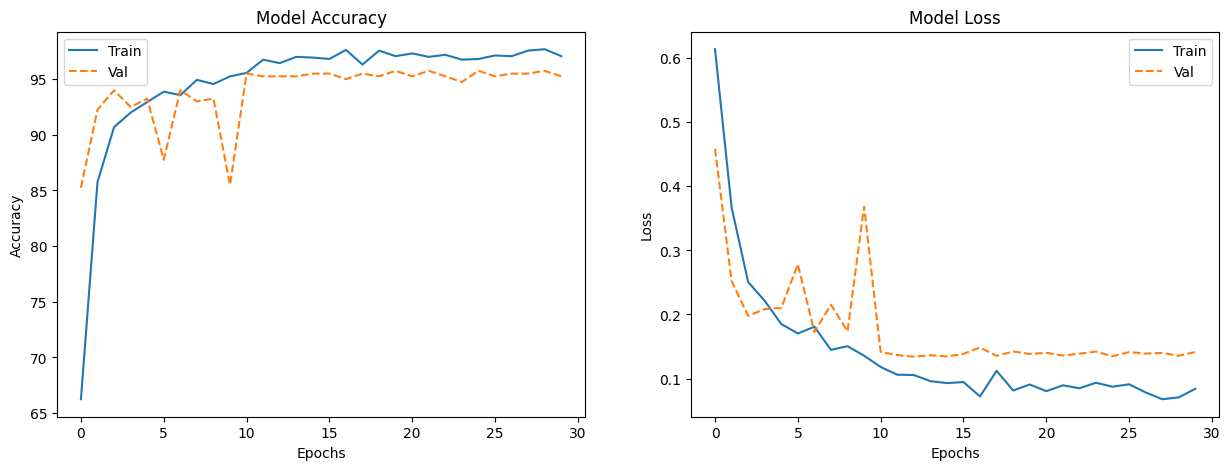

In [23]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 2, figsize=(15, 5))
plt.title('CE loss')
# Plotting training and validation accuracy
ax[0].plot(train_accuracies)
ax[0].plot(val_accuracies,linestyle = '--')
ax[0].set_title('Model Accuracy')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')
ax[0].legend(['Train', 'Val'])

# Plotting training and validation loss
ax[1].plot(train_losses)
ax[1].plot(val_losses,linestyle = '--')
ax[1].set_title('Model Loss')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss')
ax[1].legend(['Train', 'Val'])

plt.show()

# Model Evaluation with Test Set

Step 0: Download test dataset

In [30]:
!wget https://raw.githubusercontent.com/TacoXDD/homeworks/master/dataset/test/test_normal.npy
!wget https://raw.githubusercontent.com/TacoXDD/homeworks/master/dataset/test/test_pneumonia.npy

--2023-10-16 13:18:26--  https://raw.githubusercontent.com/TacoXDD/homeworks/master/dataset/test/test_normal.npy
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13107328 (12M) [application/octet-stream]
Saving to: ‘test_normal.npy.3’

test_normal.npy.3   100%[===================>]  12.50M  --.-KB/s    in 0.06s   

2023-10-16 13:18:26 (195 MB/s) - ‘test_normal.npy.3’ saved [13107328/13107328]

--2023-10-16 13:18:26--  https://raw.githubusercontent.com/TacoXDD/homeworks/master/dataset/test/test_pneumonia.npy
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting res

Step 1: Prepare your test dataset

In [31]:
import numpy as np

test_abnormal = np.load('test_pneumonia.npy')
test_normal = np.load('test_normal.npy')

print(f'Shape of test_abnormal: {test_abnormal.shape}')
print(f'Shape of test_normal: {test_normal.shape}')

# For the data having presence of pneumonia assign 1, for the normal ones assign 0.
test_abnormal_labels = np.ones((test_abnormal.shape[0],))
test_normal_labels = np.zeros((test_normal.shape[0],))

x_test = np.concatenate((test_abnormal, test_normal), axis=0)
y_test = np.concatenate((test_abnormal_labels, test_normal_labels), axis=0)

print(f'Shape of x_test: {x_test.shape}')
print(f'Shape of y_test: {y_test.shape}')

Shape of test_abnormal: (200, 256, 256)
Shape of test_normal: (200, 256, 256)
Shape of x_test: (400, 256, 256)
Shape of y_test: (400,)


Step 2: Load Test Images into PyTorch DataLoader (5 pts)

In [32]:
import torch
from torch.utils.data import DataLoader, TensorDataset, random_split

# Convert to PyTorch tensors
# 以下 x 為資料 y為資料對應的標籤；資料使用float，標籤使用long(int)
x_test = torch.from_numpy(x_test).float()
y_test = torch.from_numpy(y_test).long()

# Combine the images and labels into a dataset
test_dataset = TensorDataset(x_test, y_test)

# Create a dataloader to load data in batches. Set batch size to 32.
# Create dataloaders #把data 分成 mini batch 分次load
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)

Step 3: Prepare Your Trained Model

In [34]:
# Declare the model architecture (lab3 D.)
# model = nn.Sequential(
#     nn.Flatten(),#把圖片展成1D 65536
#     nn.Linear(256*256*1, 256), #??
#     nn.ReLU(), #
#     nn.Linear(256, 1) # Map回Class ,1: about loss, BCE cross entropy; 作業裡的 CE entropy 要用2
# ).cuda()
model = nn.Sequential(
    nn.Flatten(),

    nn.Linear(256*256*1, 64),
    nn.BatchNorm1d(64),
    nn.ReLU(),
    nn.Dropout(0.5),

    nn.Linear(64, 64),
    nn.BatchNorm1d(64),
    nn.ReLU(),
    nn.Dropout(0.5),

    nn.Linear(64, 64),
    nn.BatchNorm1d(64),
    nn.ReLU(),
    nn.Dropout(0.5),

    nn.Linear(64, 2)
).cuda()
# Load the trained weights (Loading the Best Model?)


model.load_state_dict(torch.load('model_classification.pth'))#.pth pytorch weight 會用的

# Set the model to evaluation mode
model.eval()

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=65536, out_features=64, bias=True)
  (2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): ReLU()
  (4): Dropout(p=0.5, inplace=False)
  (5): Linear(in_features=64, out_features=64, bias=True)
  (6): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (7): ReLU()
  (8): Dropout(p=0.5, inplace=False)
  (9): Linear(in_features=64, out_features=64, bias=True)
  (10): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (11): ReLU()
  (12): Dropout(p=0.5, inplace=False)
  (13): Linear(in_features=64, out_features=2, bias=True)
)

Step 4: Perform Inference and Calculate the Accuracy (10 pts)

In [35]:
# From Lab2

# Lab2 是隨機抽img 測試
# 在此直接測試整個Test data
test_correct = 0
test_total = 0

with torch.no_grad():
    for images, labels in test_loader:

        images = images.cuda()
        images = images / 255.

        labels = labels.cuda() # for BCE

        outputs = model(images)

        labels_float = labels.long()  # Convert labels to float and match shape with outputs for CE
        predicted = outputs.argmax(-1)

        test_correct += (predicted==labels).sum().item()
        test_total += labels.size(0)



train_accuracy = 100. * test_correct / test_total
print(f'Test accuracy is {train_accuracy}%.')

Test accuracy is 76.75%.
